# HW Суммаризация статей Habr

Мы собрали несколько тысяч статей с Habr, для 100 из них предстоит построить автоматическую абстрактивную суммаризацию. 
### Что нужно сделать
 - Построить суммаризации для 100 статей из файла `test_articles_clear_100.json`
 - Суммаризации оформить в нужном формате и отправить на проверку
 

### Как оценивается качество
- Качество будет оцениваться моделью, обученной на метрику **SEAHORSE Q6 Concise** 
    - Статья https://arxiv.org/abs/2305.13194
    - Данные и метрики от авторов https://github.com/google-research-datasets/seahorse
- Про обучение модели качества:
        - Мы взяли RU и EN данные из статьи SEAHORSE: A Multilingual, Multifaceted Dataset for Summarization Evaluation https://arxiv.org/abs/2305.13194
        - Обучили модель-метрику предсказывать Q6 Concise из датасета статьи (как самую высокоуровневую метрику из предложенных)
        - 10% данных ушло на dev/test
        - 90% данных ушло на обучение модели (мы обучили 2 модели, открытую и закрытую, каждая из моделей обучена на 60% данных от полного датасета)

- На вход метрике-модели текст подается в следующем формате: `"Текст статьи:\n" + Text + "\n\n" + "Краткое содержание:\n" + Summary as metric_input`

### Критерий успешного прохождения
 - Получить качество суммаризаций не хуже (с учетом статзначимости), чем у выбранного нами бейзлайна по оценке **закрытой** моделью. 
 - Качество бейзлайна по оценке открытой моделью `=0.557`
 - <i>Примечание.</i> Почему используется закрытая модель? Так как тестовые данные и модель для оценки качества открыты, то можно переобучиться и обмануть открытую модель оценки качества методом перебора.

### Что в архиве
- `test_articles_clear_100.json` - статьи, которые нужно суммаризовать.
- `train_data.json` - примеры различных суммаризаций с оценкой открытой моделью, которые можно использовать для дообучения при необхдимости.
- `example.ipynb` - jupyter ноутбук с примерами чтения данных и того, как записывать решение, то есть выходного формата. Также приведен пример запроса в API для замера качества суммаризаций во время разработки решения. 

### Формат отправки выполненного задания
- `json lines` - в каждой строке json вида `{'id': AAA, 'summary': "BBB"}` (есть в примере)


## Testset summarization example

In [3]:
import json
with open('test_articles_clear_100.json', 'r') as fin:
    test_articles = [json.loads(s) for s in fin.readlines()]

In [4]:
len(test_articles)

100

In [5]:
test_articles[0].keys()

dict_keys(['Host', 'Path', 'Text', 'id'])

In [6]:
print(test_articles[0]['Text'])

Интервью с главой ЦМИТ Иваном Мошкиным / Habr            

03-04-2017
На днях мы побывали в гостях у наших друзей и партнёров в Центре молодежного инновационного творчества «LAB3DPrint», это один из старейших ЦМИТов в России, который представляет собой площадку для обучения взрослых и детей цифровому производству, 3D-моделированию, конструированию. Помимо интересного и полезного времяпрепровождения, учащиеся получают уникальный опыт и навыки в таких инновационных направлениях, как 3D печать, 3D моделирование, робототехника, 2D черчение и лазерной резке. Центр прекрасно оснащен современным оборудованием для производства 3D-прототипов, лазерной резки, гравировки, вакуумного литья и многого другого. В конце прошлого года, наша компания начала поставки 3D-принтеров Raise3D в Россию, подписав эксклюзивный контракт с этим производителем и один из первых 3D-принтеров Raise3D N2 Plus был установлен в Лаборатории трёхмерной печати. Мы обсудили с Иваном Мошкиным, создателем и руководителем Лабор

In [7]:
def dummy_summarization(text):
    return text[:50]


result = [
    {
        'id': row['id'], 
        'summary': dummy_summarization(row['Text'])
    }
    for row in test_articles
]

In [8]:
result[0].keys(), len(result)

(dict_keys(['id', 'summary']), 100)

In [9]:
result[:4]

[{'id': 1, 'summary': 'Интервью с главой ЦМИТ Иваном Мошкиным / Habr     '},
 {'id': 2, 'summary': 'Подборка @pythonetc, октябрь 2019 / Habr          '},
 {'id': 3, 'summary': 'Владислав Улендеев: «Мы создаём отдельный холдинг,'},
 {'id': 4, 'summary': 'Уникальный стабилизатор Штиль Инстаб 500 / Habr   '}]

In [12]:
with open('test_output_example_jsonlines.json', 'w') as fout:
    fout.write("\n".join([
        json.dumps(row, ensure_ascii=False, indent=4)
        for row in result
    ]))

## Train Dataset 
В обучающем датасете собраны суммаризации разного качества (и лучше бейзлайна и хуже) и оценка качества по открытой модели для них.

In [13]:
import json
with open('train_data.json', 'r') as fin:
    train_data = [json.loads(s) for s in fin.readlines()]

In [14]:
len(train_data)

11100

In [15]:
train_data[0].keys()

dict_keys(['Text', 'metric', 'metric_input', 'summary'])

In [22]:
print(train_data[0]["Text"])
print(train_data[0]["metric_input"])
print(train_data[0]["summary"])

«За сотню»: две «вертушки» для винила от Pro-Ject и Technics / Habr              

29-10-2021
В прошлый раз мы поговорили о проигрывателях от Yamaha, Denon и TEAC в сегменте «до 60 тысяч рублей», а потом продвинулись дальше с обзором чуть более дорогих систем от Denon и Pro-Ject. Сегодня переходим планку в сто тысяч за вертушку и смотрим, что готовы предложить за эту сумму бренды Pro-Ject и Technics. Проигрыватель Pro-Ject X2 — Audiomania.ru [ 105 000 ] Pro-Ject X2 — это одна из наиболее свежих разработок инженеров этого бренда. Проигрыватель производят в Европе, поэтому в качестве используемых материалов и реализации выбранных ими решений сомневаться не приходится. Шасси выполнено из MDF и имеет внушительную толщину — 50 мм. При общих габаритах системы [460 х 150 х 340 мм] это — серьезный показатель, как и ее существенный вес — 10 кг. Два килограмма из десяти приходятся на 300-мм опорный акриловый диск толщиной 30 мм. Он установлен на скрытый субдиск, опирающийся на подшипник из стали

In [23]:
[r['metric'] for r in train_data[:5]]

[0.4780273438, 0.6215820313, 0.5087890625, 0.5239257813, 0.5952148438]

#### Пример

In [11]:
print(train_data[0]['Text'])

«За сотню»: две «вертушки» для винила от Pro-Ject и Technics / Habr              

29-10-2021
В прошлый раз мы поговорили о проигрывателях от Yamaha, Denon и TEAC в сегменте «до 60 тысяч рублей», а потом продвинулись дальше с обзором чуть более дорогих систем от Denon и Pro-Ject. Сегодня переходим планку в сто тысяч за вертушку и смотрим, что готовы предложить за эту сумму бренды Pro-Ject и Technics. Проигрыватель Pro-Ject X2 — Audiomania.ru [ 105 000 ] Pro-Ject X2 — это одна из наиболее свежих разработок инженеров этого бренда. Проигрыватель производят в Европе, поэтому в качестве используемых материалов и реализации выбранных ими решений сомневаться не приходится. Шасси выполнено из MDF и имеет внушительную толщину — 50 мм. При общих габаритах системы [460 х 150 х 340 мм] это — серьезный показатель, как и ее существенный вес — 10 кг. Два килограмма из десяти приходятся на 300-мм опорный акриловый диск толщиной 30 мм. Он установлен на скрытый субдиск, опирающийся на подшипник из стали

In [12]:
print(train_data[0]['summary'])

В статье рассматриваются два проигрывателя винила от Pro-Ject и Technics, которые стоят дороже 100 тысяч рублей. Pro-Ject X2 имеет массивное шасси и акриловый опорный диск, а его тонарм интегрирован с шеллом для установки звукоснимателей. Technics SL-1200 MK7 имеет прямой привод и регулируемую скорость вращения.


In [13]:
print(train_data[0]['metric'])

0.4780273438


#### Еще пример

In [14]:
train_data[200]['Text']

'Тварь дрожащая или генеральный директор? / Habr           \n\n29-04-2016\nГенеральный директор является важным элементом в работе компании, как бы при этом его ни называли – президент, управляющий, генеральный или просто директор, суть от это не меняется. Но, как показывает практика, не все компании – от стартапов до корпораций – умеют «правильно их готовить». Да и сам руководитель должен понимать, что его ответственность достаточно обширна и он получает не только красивое кресло, но и много обязанностей в довесок к нему. Шаг 1. Назначение Единоличный исполнительный орган (директор) назначается по решению общего собрания участников или советом директоров (если такой орган создан и Уставом компании этот вопрос отнесен к его компетенции). В случае если в обществе только один участник, он принимает решение единолично и назначает директора. Заметим, что единственный участник ООО и индивидуальный предприниматель – вещи абсолютно разные. У ИП хоть и могут быть сотрудники, но нет Устава и не

In [15]:
print(train_data[200]['summary'], train_data[200]['metric'])

Статья обсуждает роль и обязанности генерального директора в компании, начиная с назначения и заканчивая увольнением. 

Основные шаги: 1. Назначение директора. 2. Определение его полномочий. 3. Оформление трудовых отношений. 4. Увольнение директора. 

Важные аспекты: 1. Директор не владеет компанией, а является наемным работником. 2. Директор может быть дисквалифицирован за нарушение правил. 3. Ответственность директора может быть ограничена его личным имуществом. 4. В случае претензий со стороны контрагентов отвечать будет директор, указанный в ЕГРЮЛ. 0.6391601563


### Найдем несколько некачественных примеров

In [16]:
for r in train_data:
    if r['metric'] < 0.4:
        print(r['metric'], r['summary'])
        break

0.1728515625 Паттерны разработки: MVC vs MVP vs MVVM vs MVI / Хабр                

От переводчика: данная статья является переработкой английской статьи по паттернам разработки. В процессе адаптации на русский немало пришлось изменить. Оригинал Выбор между различными паттернами разработки, всегда сопровождается рядом споров и дискуссий, а разные взгляды разработчиков на это еще больше усложняют задачу. Существует ли решение этой идеологической проблемы? Давайте поговорим о MVC, MVP, MVVM и MVI прагматично. Давайте ответим на вопросы: “Почему?”, “Как найти консенсус?” Вступление Вопрос выбора между MVC, MVP, MVVM и MVI коснулся меня, когда я делал приложение для Warta Mobile вместе с моей командой. Нам было необходимо продвинуться от минимально жизнеспособного продукта к проверенному и полностью укомплектованному приложению, и мы знали, что необходимо будет ввести какую-либо архитектуру. У многих есть непоколебимое мнение насчет различных паттернов разработки. Но когда вы рассматривает

In [17]:
for r in train_data:
    if r['metric'] < 0.15:
        print(r['metric'], r['summary'])
        break

0.05645751953 В статье обсуждаются 14 книг, которые, по мнению экспертов Y Combinator, стоит прочитать в 2016 году. Среди них:

- "Как знать" Пола Грэма - о важности чтения и влиянии книг на мировоззрение.
- "Прекрасное и ужасающее видение нашего возможного будущего" от автора "Pokémon Go" Лука Иземана.
- "Hadrian's Wall" Пола Грэма - история Римской империи.
- "Magicians Trilogy" - эпическая история с яркими образами.
- "Expanse Collection" - космическая опера с глубокой сюжетной линией.
- "End of Cycle?" - размышления о конце экономического цикла технологий.
- "Our Mathematical Universe" и "The Beginning of Infinity" Мичио Тегмарка и Дэвида Дойча - книги о природе реальности.
- "Team of Rivals" - о политическом гении Авраама Линкольна.
- "Algorithms to Live By" - принципы computer science для принятия решений.
- "Moral Tribes" - исследование различий в интуиции о морали.
- "Work Rules!" - идеи для руководителей компаний.
- "The Intelligent Investor" Бенджамина Грэма - книга о инвести

In [25]:
for idx, r in enumerate(train_data):
    if r['metric'] < 0.05:
        print(r['metric'], r['summary'])
        break

0.04858398438 Статья рассказывает о влиянии советских игровых автоматов на игровую индустрию. В 1971 году в Москве прошла выставка американских и японских автоматов, после которой советские инженеры создали свои аналоги. Они пользовались популярностью, особенно автоматы "Морской бой", "Магистраль", "Городки", "Снайпер" и "Баскетбол". В 80-х годах автоматы стали популярны благодаря инфляции и инфляции, но некоторые из них все еще работают.


In [27]:
train_data[idx]['Text']

'Советские игровые автоматы / Хабр                 \n\n24-07-2015\nРазработчиками игр, геймдизайнерами и хардкорными игроками не рождаются. Мое поколение, например, выросло на ранних консолях и закалилось суровым ПК-геймингом 90-х. Но люди увлекались видеоиграми еще задолго до того, как 8-битные приставки появились в каждом доме. Я говорю о предшественниках консолей – советских игровых автоматах. Не каждый читатель этой статьи видел их вживую. А всего 25 лет назад школьники сломя голову неслись в игровой зал после (а то и вместо) уроков. Нелепые по нынешним меркам квадратики на выпуклых экранах для кого-то стали первыми виртуальными мирами, где их ждали захватывающие приключения и яркие победы. Эти школьники выросли. А некоторые из них даже посвятили жизнь созданию видеоигр. Поэтому влияние советских аркадных автоматов на отечественную игровую индустрию нельзя недооценивать. Появление В 1971 году в московском парке им. Горького проходила международная выставка «Аттракцион-71». Полтора 

### Посмотрим на распределение

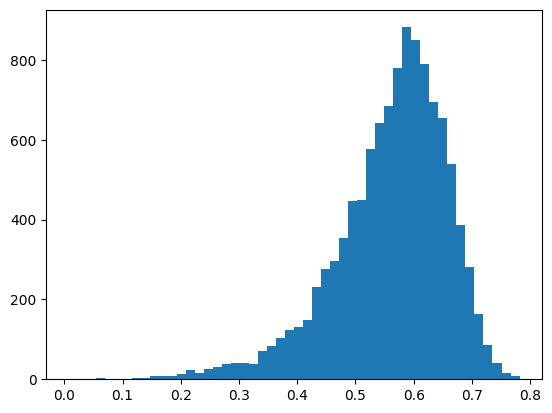

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([r['metric'] for r in train_data], bins=50);

In [31]:
import numpy as np
np.mean([r['metric'] for r in train_data])

0.5613022328503209

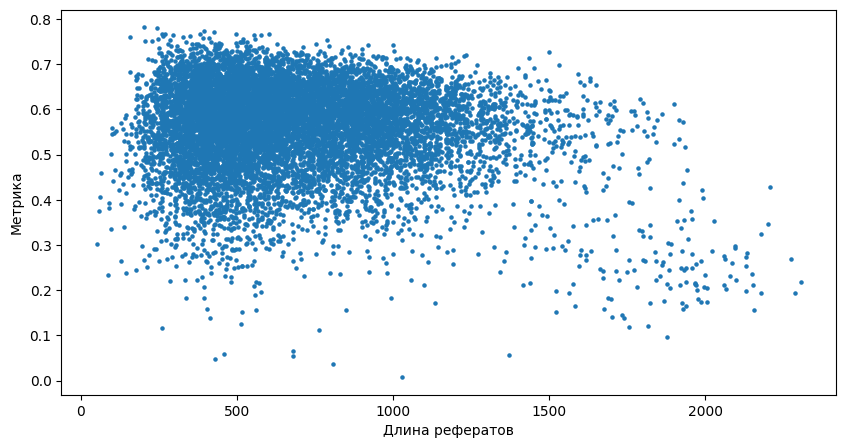

In [52]:
plt.figure(figsize=(10, 5))
plt.scatter(
    [len(r['summary']) for r in train_data],
    [r['metric'] for r in train_data],
    s=5
)
plt.xlabel('Длина рефератов')
plt.ylabel('Метрика')
plt.show()

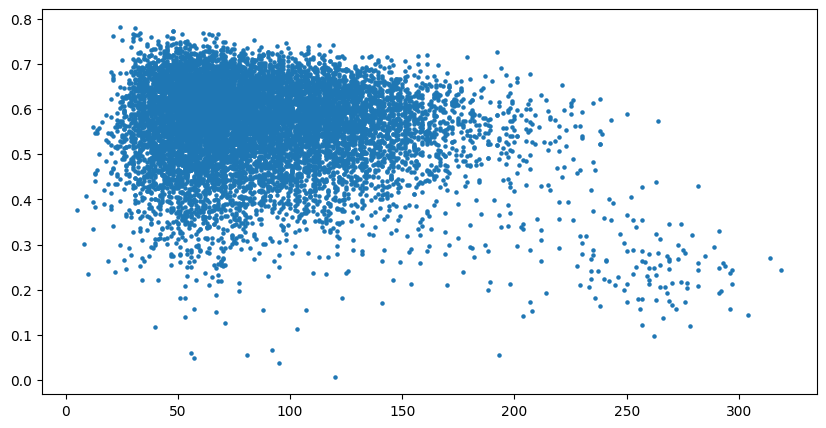

In [53]:
plt.figure(figsize=(10, 5))
num_words = [len(r['summary'].strip().split(" ")) for r in train_data]
plt.scatter(
    num_words,
    [r['metric'] for r in train_data],
    s=5
)

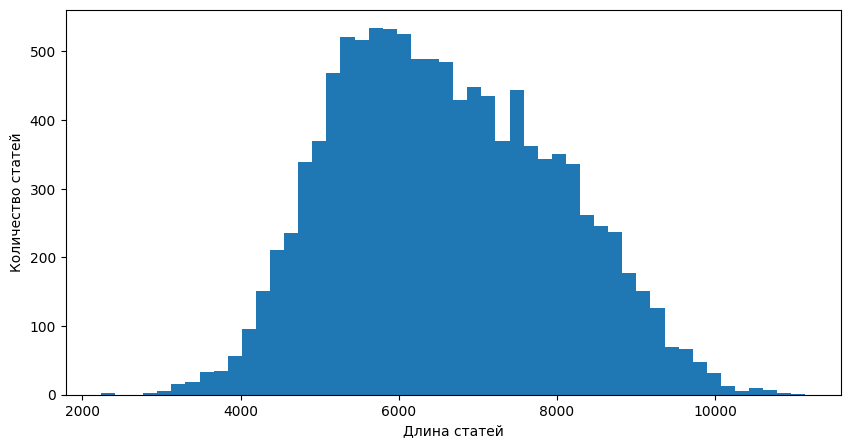

In [77]:
def make_hist_article_len(train_data):
    plt.figure(figsize=(10, 5))
    plt.hist([len(r['Text'].strip()) for r in train_data], bins=50)
    plt.xlabel('Длина статей')
    plt.ylabel('Количество статей')
    plt.show()
make_hist_article_len(train_data)

In [83]:
train_data_high_score = [r for r in train_data if r['metric'] > 0.6]
len(train_data_high_score)

4304

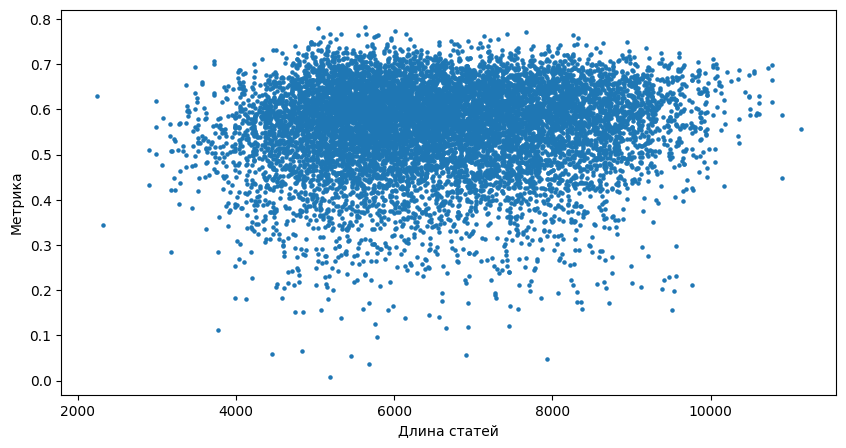

In [80]:
def scatter_article_len_vs_metric(train_data_high_score):
    plt.figure(figsize=(10, 5))
    plt.scatter(
        [len(r['Text'].strip()) for r in train_data_high_score],
        [r['metric'] for r in train_data_high_score],
        s=5
    )
    plt.xlabel('Длина статей')
    plt.ylabel('Метрика')
    plt.show()
scatter_article_len_vs_metric(train_data)

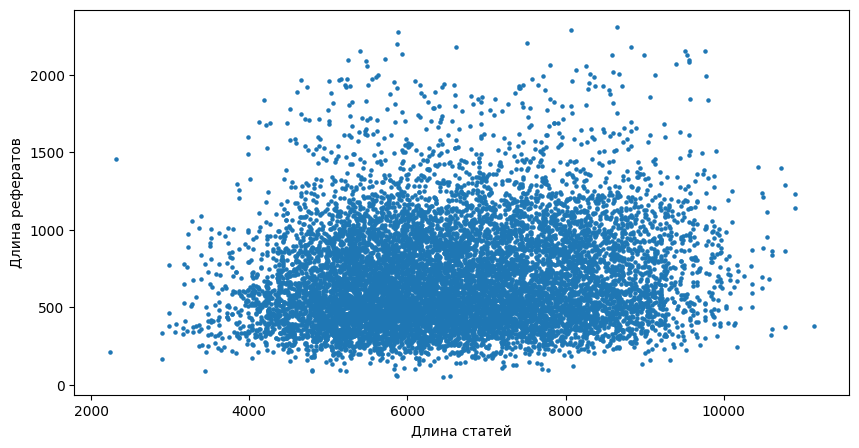

In [81]:
def scatter_article_len_vs_summary_len(train_data):
    plt.figure(figsize=(10, 5))
    plt.scatter(
        [len(r['Text'].strip()) for r in train_data],
        [len(r['summary'].strip()) for r in train_data],
        s=5
    )
    plt.xlabel('Длина статей')
    plt.ylabel('Длина рефератов')
    plt.show()
scatter_article_len_vs_summary_len(train_data)

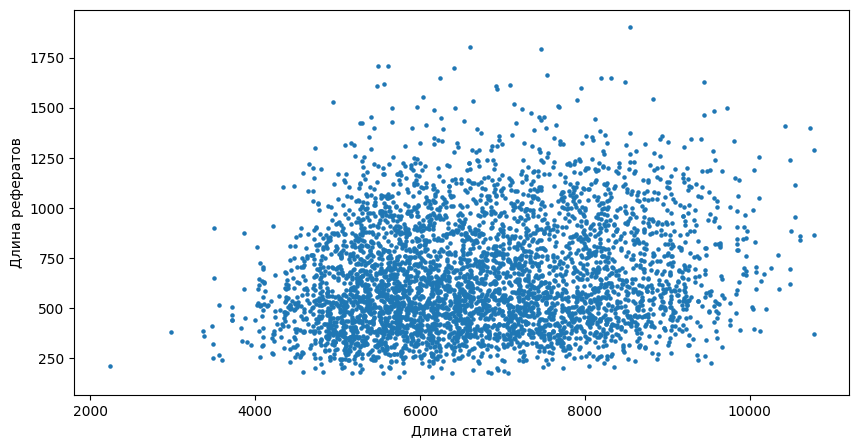

In [84]:
scatter_article_len_vs_summary_len(train_data_high_score)

In [44]:
import requests
import json

def eval_metric_model(article, summary):
    full_input = f"Текст статьи:\n{article}\n\nКраткое содержание:\n{summary}"

    resp = requests.post(
        url="https://node-api.datasphere.yandexcloud.net/classify", 
        json={
            "Text": full_input,
        },
        headers={
            "Authorization": f"Api-Key AQVNyVqBi-XoJ1cAo7VIxq6ztgXm3owqowtso5Qb",
            "x-node-alias": "datasphere.user.yagpt-seminar-hw",
        }
        
    )
        
    return json.loads(resp.text)["Scores"][0]

In [ ]:
from utils import eval_metric_model

idx = 1087
article = train_data[idx]['Text']
# summary = '''Статья описывает историю и влияние советских аркадных автоматов на игровую индустрию. В начале 1970-х, советские граждане впервые столкнулись с американскими и японскими игровыми автоматами на выставке в Москве, что привело к созданию собственных советских аналогов. Эти автоматы, произведенные на военных заводах, отличались от западных: они не сохраняли лучшие результаты, не выдавали призы и имели счетчики монет. Автоматы располагались в общественных местах и пользовались большой популярностью, способствуя развитию интереса к видеоиграм в СССР. Среди популярных игр были "Морской бой", "Магистраль", "Городки", "Снайпер" и "Баскетбол". В статье также упоминается о влиянии этих автоматов на современную игровую индустрию, а также о создании Музея советских автоматов и эмулятора "Советские игровые автоматы" для сохранения истории этих устройств.'''
summary = '''Статья рассматривает влияние советских игровых автоматов на развитие отечественной игровой индустрии. Указывается, что популярность этих автоматов началась задолго до распространения 8-битных приставок в домах. Особое внимание уделяется историческому моменту 1971 года, когда на московской выставке «Аттракцион-71» советские граждане впервые познакомились с американскими и японскими игровыми автоматами. Скоро после этого появились советские автоматы, многие из которых были точными копиями западных образцов.
В статье подчеркивается уникальность советских автоматов: они не запоминали лучший результат, вместо призов давали дополнительное игровое время и оснащались счетчиком монет. Также отмечается, что эти автоматы производились на военных заводах и были дорогостоящими.
Статья охватывает период популярности этих устройств и их постепенное исчезновение в 80-х годах из-за инфляции и перехода на домашние компьютеры и игровые приставки.
Также описывается наследие этих автоматов: создание Музея советских автоматов в Москве и разработка эмулятора "Советские игровые автоматы" компанией Sky Horse Games, что демонстрирует непреходящий интерес к этой теме. В заключение статьи поднимается вопрос о том, остались ли где-то рабочие советские автоматы, приглашая читателей поделиться своими воспоминаниями и знаниями об этих устройствах.'''
print(len(summary.strip()))

eval_metric_model(article, summary.strip())

1337


0.530273

# API для измерения качества
Проверим на конкретном примере

In [ ]:
summary = train_data[200]['summary']
article = train_data[200]['Text']
print('metric', train_data[200]['metric'])

metric 0.6391601563


In [ ]:
len(summary)

558

In [ ]:
article.strip()

'Тварь дрожащая или генеральный директор? / Habr           \n\n29-04-2016\nГенеральный директор является важным элементом в работе компании, как бы при этом его ни называли – президент, управляющий, генеральный или просто директор, суть от это не меняется. Но, как показывает практика, не все компании – от стартапов до корпораций – умеют «правильно их готовить». Да и сам руководитель должен понимать, что его ответственность достаточно обширна и он получает не только красивое кресло, но и много обязанностей в довесок к нему. Шаг 1. Назначение Единоличный исполнительный орган (директор) назначается по решению общего собрания участников или советом директоров (если такой орган создан и Уставом компании этот вопрос отнесен к его компетенции). В случае если в обществе только один участник, он принимает решение единолично и назначает директора. Заметим, что единственный участник ООО и индивидуальный предприниматель – вещи абсолютно разные. У ИП хоть и могут быть сотрудники, но нет Устава и не

0.638672

Получили значения, отличающиеся на < 1пп
- В датасете: `0.6391601563` 
- В API: `0.638672`

Отличие вызвано различием в фреймворках инференса моделей, но не влияет на качество. 

# Доступ к YaGPT

In [23]:
request = "Локация: Москва, Метраж: 40кв. м"
result = requests.post(
    url='https://llm.api.cloud.yandex.net/llm/v1alpha/instruct',
    headers={
        "Authorization": f"Api-Key AQVNyVqBi-XoJ1cAo7VIxq6ztgXm3owqowtso5Qb",
    },
    json={
      "model": "general",
      "instruction_text": "Ниже перечислены характеристики недвижимости.",
      "request_text": f"{request}\n\nНа основании этой информации о недвижимости ниже напиши продающий текст на русском. Текст не должен содержать лжи и полностью соответствовать данным из характеристик.",
      "generation_options": {
        "max_tokens": 1500,  
        "temperature": 0.5
      }
    }
)


In [25]:
result.text

'{"result":{"alternatives":[{"text":"Ищете квартиру в Москве? У нас есть отличный вариант для вас! Наша квартира площадью 40 квадратных метров расположена в прекрасном районе города.\\n\\nЭто уютное и комфортное жилье, которое идеально подойдет для тех, кто ищет недорогую и уютную квартиру. Квартира находится на удобном этаже, что обеспечивает легкий доступ к лифту.\\n\\nВ квартире сделан хороший ремонт, который позволит вам сразу же заселиться и наслаждаться комфортом. Кроме того, в квартире есть все необходимое для жизни: мебель, бытовая техника и даже кондиционер.\\n\\nЛокация нашей квартиры очень удобна для тех, кто хочет жить в центре города. Рядом есть все необходимые объекты инфраструктуры: магазины, рестораны, школы и детские сады. Кроме того, вы сможете быстро добраться до любой точки города на общественном транспорте.\\n\\nНе упустите свой шанс приобрести эту замечательную квартиру по доступной цене! Звоните прямо сейчас и записывайтесь на просмотр!","score":-0.31903085112571

In [26]:
json.loads(result.text)['result']['alternatives'][0]['text']

'Ищете квартиру в Москве? У нас есть отличный вариант для вас! Наша квартира площадью 40 квадратных метров расположена в прекрасном районе города.\n\nЭто уютное и комфортное жилье, которое идеально подойдет для тех, кто ищет недорогую и уютную квартиру. Квартира находится на удобном этаже, что обеспечивает легкий доступ к лифту.\n\nВ квартире сделан хороший ремонт, который позволит вам сразу же заселиться и наслаждаться комфортом. Кроме того, в квартире есть все необходимое для жизни: мебель, бытовая техника и даже кондиционер.\n\nЛокация нашей квартиры очень удобна для тех, кто хочет жить в центре города. Рядом есть все необходимые объекты инфраструктуры: магазины, рестораны, школы и детские сады. Кроме того, вы сможете быстро добраться до любой точки города на общественном транспорте.\n\nНе упустите свой шанс приобрести эту замечательную квартиру по доступной цене! Звоните прямо сейчас и записывайтесь на просмотр!'